# The `opencadd.structure.pocket` module

Let's walk through the functionalities offered in the `opencadd.structure.pocket` module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd

from opencadd.databases.klifs import setup_remote
from opencadd.structure.pocket import Pocket, AnchorResidue

INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.


## Get example protein structure and pocket residues

In [3]:
from opencadd.databases.klifs import setup_remote
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


__Download protein structure file (or use your own file)__

First of all, we download structural data for an example protein kinase with PDB ID `4wsq` alternate model A and chain A from the KLIFS database:

https://klifs.vu-compmedchem.nl/details.php?structure_id=3834

In [4]:
structure_klifs_id = 3834

In [5]:
filepath = remote.coordinates.to_mol2(structure_klifs_id, ".", "protein")
filepath

PosixPath('HUMAN_AAK1_4wsq_altA_chainA_protein.mol2')

At the end of this notebook, we will delete this file again.

__Fetch pocket residues (or use your own pocket residues)__



In [6]:
pocket_residues = remote.pockets.by_structure_klifs_id(structure_klifs_id)
pocket_residues

residue.klifs_id residue.id residue.klifs_region_id residue.klifs_region  \
0                  1         50                     I.1                    I   
1                  2         51                     I.2                    I   
2                  3         52                     I.3                    I   
3                  4         53                   g.l.4                  g.l   
4                  5         54                   g.l.5                  g.l   
..               ...        ...                     ...                  ...   
80                81        194                 xDFG.81                 xDFG   
81                82        195                 xDFG.82                 xDFG   
82                83        196                 xDFG.83                 xDFG   
83                84        197                  a.l.84                  a.l   
84                85        198                  a.l.85                  a.l   

   residue.klifs_color  
0                khaki  
1                khaki  
2                khaki  
3                green  
4                green  
..                 ...  
80      cornflowerblue  
81      cornflowerblue  
82      cornflowerblue  
83      cornflowerblue  
84      cornflowerblue  

[85 rows x 5 columns]

In [7]:
pocket_residue_ids = pocket_residues["residue.id"].to_list()
print(*pocket_residue_ids)

50 51 52 53 54 55 56 57 58 59 60 61 62 71 72 73 74 75 76 86 87 88 89 90 91 92 93 94 95 96 97 98 101 102 103 104 105 106 107 108 109 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 192 193 194 195 196 197 198


In [8]:
pocket_residue_labels = pocket_residues["residue.klifs_id"].to_list()
print(*pocket_residue_labels)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85


## Pocket (`Pocket` class)

The `Pocket` class currently holds the following attributes/properties:

- `name`: Protein/pocket name
- `filepath`: Path to file with structural protein data
- `centroid`: Centroids of all pocket residues' CA atoms
- `subpockets`: Subpockets defined based on a set of anchor residues each
- `regions`: User-defined regions that are of importance for the protein/pocket
- `anchor_residues`: Anchor residues to define one or more subpockets

### Initialize pocket

We initialize the pocket with the following parameters:
- Protein structure data
- Protein/pocket name
- Pocket residues PDB IDs
- Pocket residue labels (optionally), e.g. for the pocket alignment IDs

In [9]:
from opencadd.structure.pocket import Pocket

In [10]:
pocket = Pocket.from_file(
    filepath, 
    pocket_residue_ids, 
    "example kinase", 
    pocket_residue_labels
)

Note: If residue PDB IDs and labels do not match in length, a `ValueError` will be thrown.

In [11]:
try: 
    pocket = Pocket.from_file(
    filepath, 
    [1, 2, 3], 
    "example kinase", 
    [1, 2]
)
except ValueError as e:
    print(e)

Number of residue IDs and labels must be of same length.


Let's take a look at the `Pocket` class attributes/properties after initialization.

__Pocket name__

In [12]:
pocket.name

'example kinase'

__Protein structure data__

In [13]:
pocket._text[:100]

'@<TRIPOS>MOLECULE\n4wsq.A\n4885 4934 317 0 0 \nBIOPOLYMER\nUSER_CHARGES\n\n\n@<TRIPOS>ATOM\n   1 N       10.'

In [14]:
pocket._extension

'mol2'

In [15]:
pocket.data.head()

atom.id atom.name   atom.x  atom.y     atom.z residue.id residue.name
0        1         N  10.2784  4.1662  49.948399         29          GLY
1        2        H1  10.2440  3.1868  50.192699         29          GLY
2        3        H2   9.9911  4.2838  48.987301         29          GLY
3        4        H3   9.6568  4.6858  50.551498         29          GLY
4        5        CA  11.6355  4.6586  50.111801         29          GLY

__Pocket residues__

In [16]:
pocket.residues.head()

residue.id residue.label
0         50             1
1         51             2
2         52             3
3         53             4
4         54             5

__Pocket centroids__

In [17]:
pocket.centroid

array([ 1.1348164, 20.79171  , 36.3045   ], dtype=float32)

__Subpockets and regions__

We have not set any subpockets or regions (`None`), yet:

In [18]:
pocket.subpockets

In [19]:
pocket.regions

### Add subpockets

Next, we can add subpockets one-by-one to the pocket. For each subpocket we define the following:
- Subpocket __name__, 
- Subpocket __color__, 
- __Residue PDB IDs__ of all __anchor residues__, i.e. the residues determining the subpocket center (centroid of all anchor residues' CA atoms) and 
- __Residue labels__ for all __anchor residues__ (optionally), e.g. if we want to pass an alignment ID to each residue.

The class method `add_subpocket` uses the `Subpocket` class to set up subpockets.

In [20]:
pocket.add_subpocket("hinge_region", [73, 128, 193], "magenta", [16, 47, 80])
pocket.add_subpocket("dfg_region", [76, 90, 194], "cornflowerblue", [19, 24, 81])
pocket.add_subpocket("front_pocket", [55, 129, 181], "cyan", [6, 48, 75])

Using the `Pocket`'s property `subpockets`, we get an overview of all specified subpockets.

In [21]:
pocket.subpockets

subpocket.name subpocket.color                     subpocket.center
0   hinge_region         magenta    [1.9576334, 21.923767, 41.690033]
1     dfg_region  cornflowerblue      [7.6133666, 20.0352, 33.424603]
2   front_pocket            cyan  [-0.55436677, 15.943934, 39.561466]

Using the `Pocket`'s property `anchor_residues`, we get an overview of all subpockets' anchor residues.

In [22]:
pocket.anchor_residues

subpocket.name subpocket.color anchor_residue.id  \
0   hinge_region         magenta                73   
1   hinge_region         magenta               128   
2   hinge_region         magenta               193   
3     dfg_region  cornflowerblue                76   
4     dfg_region  cornflowerblue                90   
5     dfg_region  cornflowerblue               194   
6   front_pocket            cyan                55   
7   front_pocket            cyan               129   
8   front_pocket            cyan               181   

  anchor_residue.id_alternative anchor_residue.label  \
0                          None                   16   
1                          None                   47   
2                          None                   80   
3                          None                   19   
4                          None                   24   
5                          None                   81   
6                          None                    6   
7                          None                   48   
8                          None                   75   

         anchor_residue.center  
0    [7.675, 21.5254, 43.5183]  
1  [-0.3245, 23.4828, 45.9722]  
2  [-1.4776, 20.7631, 35.5796]  
3  [13.7391, 16.4906, 37.1612]  
4   [7.5673, 24.3155, 29.4688]  
5   [1.5337, 19.2995, 33.6438]  
6   [5.5627, 10.2881, 37.6314]  
7  [-3.6779, 21.6755, 45.6664]  
8  [-3.5479, 15.8682, 35.3866]

### Add regions

The `Pocket` class also allows to specify pocket regions, normally used to store key regions, such as the hinge region or the catalytic loop in kinases. This information can be used for pocket visualization.

The class method `add_regions` uses the `Regions` class to set up regions.

In [23]:
pocket.add_region("hinge", [127, 128, 129], "magenta", [46, 47, 48])
pocket.add_region("linker", [130, 131, 132, 133],"cyan", [49, 50, 51, 52])
pocket.add_region("xDFG", [193, 194, 195, 196], "cornflowerblue", [80, 81, 82, 83])

In [24]:
pocket.regions

region.name    region.color residue.id residue.label
0        hinge         magenta        127            46
1        hinge         magenta        128            47
2        hinge         magenta        129            48
3       linker            cyan        130            49
4       linker            cyan        131            50
5       linker            cyan        132            51
6       linker            cyan        133            52
7         xDFG  cornflowerblue        193            80
8         xDFG  cornflowerblue        194            81
9         xDFG  cornflowerblue        195            82
10        xDFG  cornflowerblue        196            83

### Visualize pocket

In [25]:
view = pocket.visualize()
view.control.center([1, 20, 36])
view.control.zoom(0.5)
view

NGLWidget()

In [26]:
view.render_image(),

(Image(value=b'', width='99%'),)

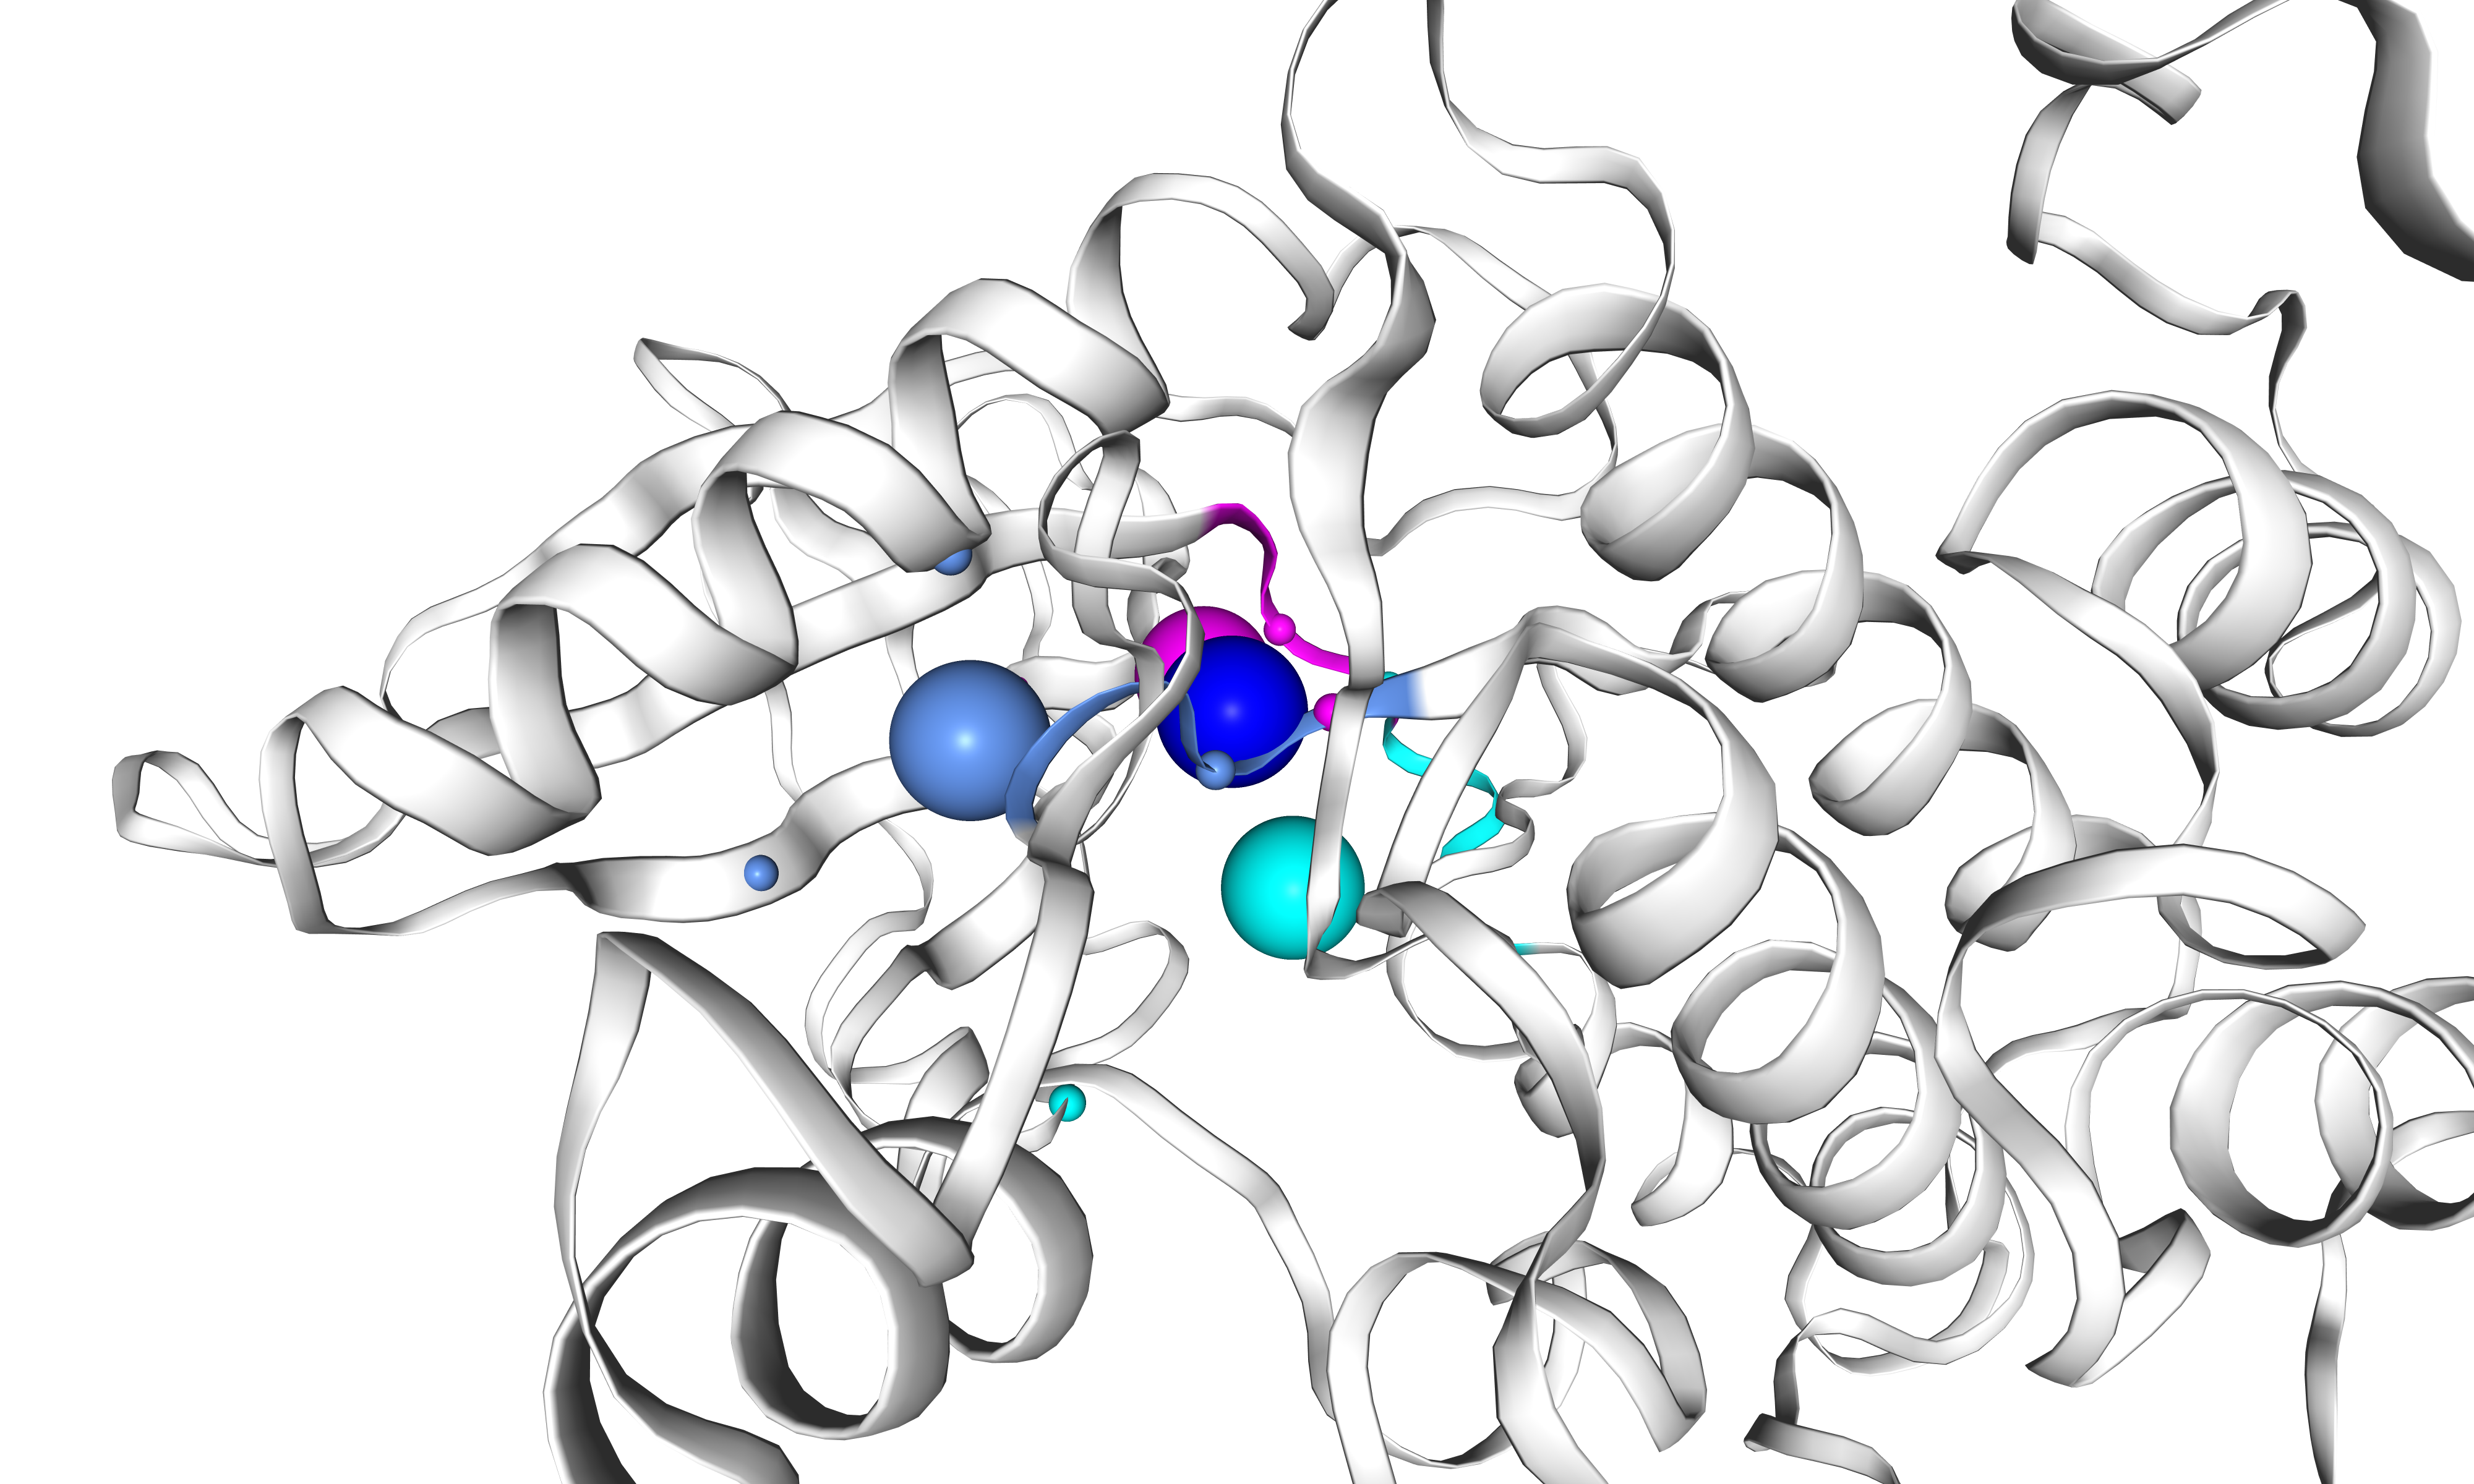

In [27]:
# Static output
view._display_image()

## KLIFS pocket (`KlifsPocket` class)

The `KlifsPocket` class is a child of the `Pocket` class, setting the kinase pocket regions as defined by KLIFS. 

![ba](https://klifs.net/images/faq/colors.png)

_Figure 1_: Kinase pocket regions as defined by KLIFS (taken from the [KLIFS publication](https://pubs.acs.org/doi/abs/10.1021/jm400378w))

In [28]:
import pandas as pd
from opencadd.structure.pocket import KlifsPocket

Define subpockets (name and color) based on user-defined KLIFS residue IDs.

In [29]:
subpockets = {
    "anchor_residue.klifs_ids": [[16, 47, 80], [19, 24, 81], [6, 48, 75]],
    "subpocket.name": ["hinge_region", "dfg_region", "front_pocket"],
    "subpocket.color": ["magenta", "cornflowerblue", "cyan"]
}
subpockets = pd.DataFrame(subpockets)
subpockets

anchor_residue.klifs_ids subpocket.name subpocket.color
0             [16, 47, 80]   hinge_region         magenta
1             [19, 24, 81]     dfg_region  cornflowerblue
2              [6, 48, 75]   front_pocket            cyan

In [30]:
kinase_pocket = KlifsPocket.from_structure_klifs_id(structure_klifs_id, subpockets)

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


### Visualize pocket with all KLIFS-defined regions

In [31]:
view = kinase_pocket.visualize()
view.add_representation("ball+stick", selection="STI")  # Show STI
view.control.center([1, 20, 36])
view.control.zoom(0.5)
view

NGLWidget()

In [32]:
view.render_image(),

(Image(value=b'', width='99%'),)

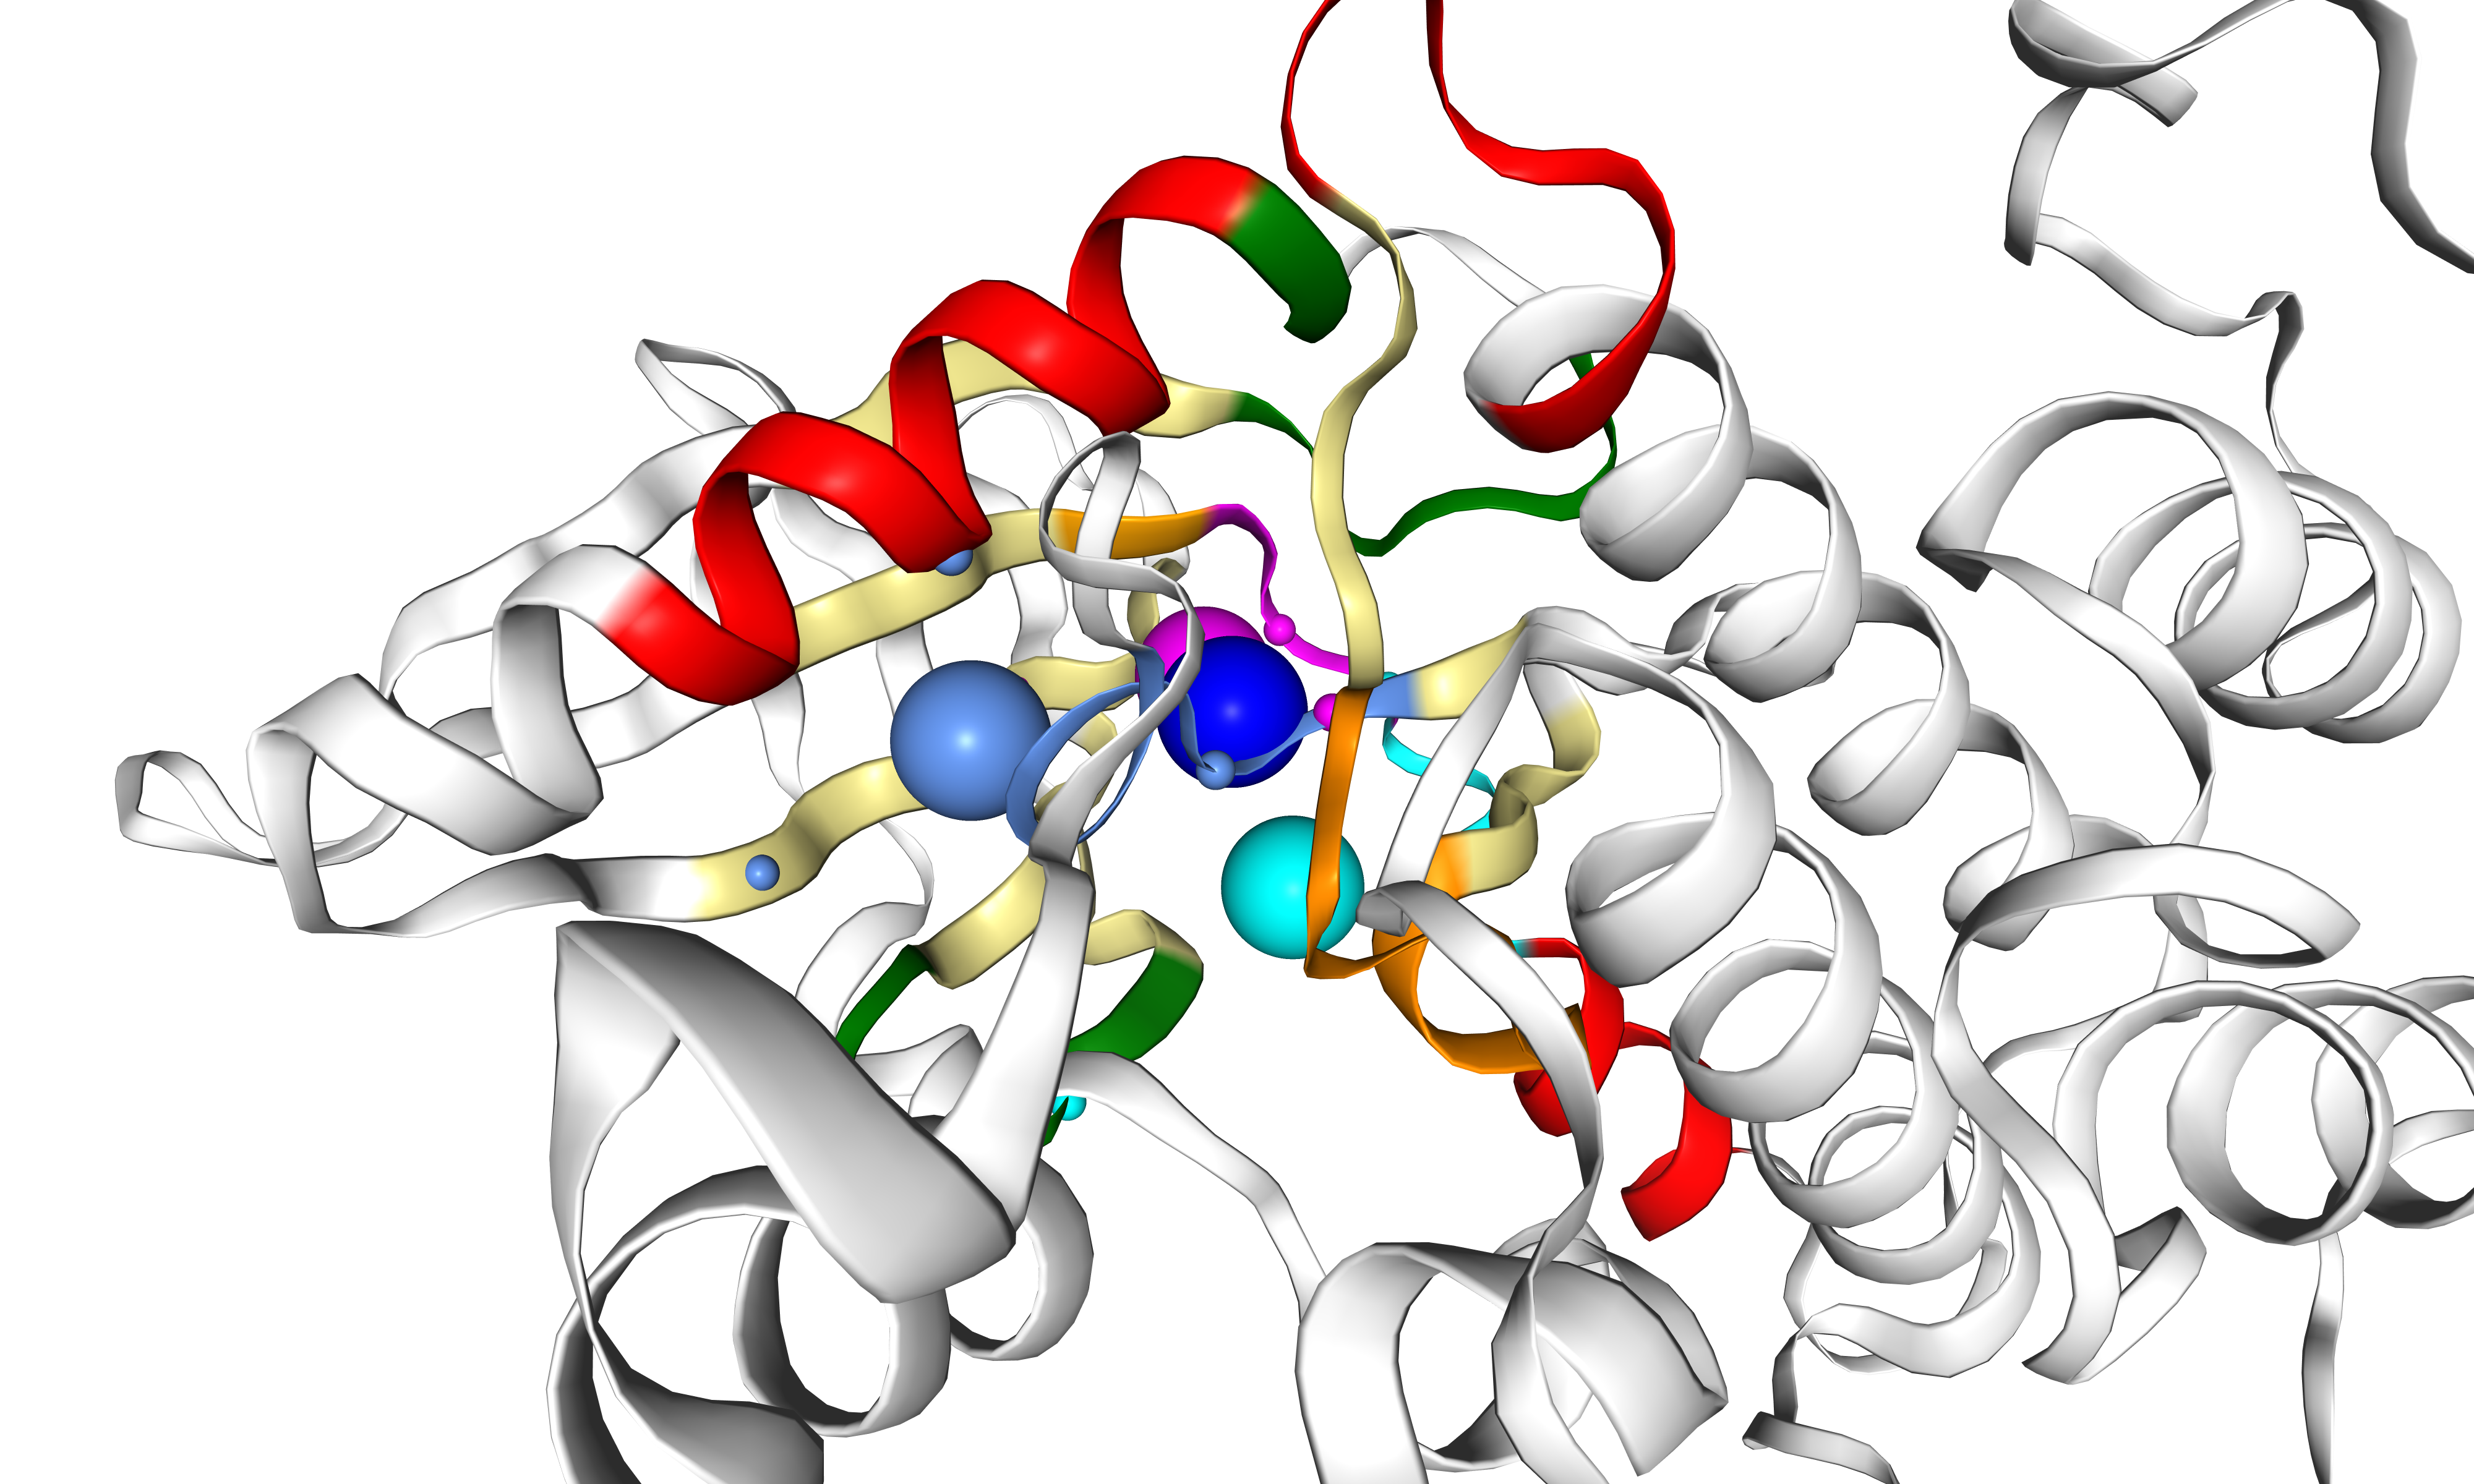

In [35]:
# Static output
view._display_image()

## Anchor residue (`AnchorResidue` class)

Subpockets are calculated based on so class anchor residues, defined each in an `AnchorResidue` class. Subpocket centers are the centroids of all anchor residues' centers (i.e. normally the CA atoms).

- If the anchor residue's CA atom is available in the input structure is available, its coordinates are defined as the anchor residues center (__case 1__).
- If the anchor residue's CA atom is missing in a structure, alternative anchors are chosen if possible: If the residue CA atoms before and after the input anchor residue are available, their CA atoms' centroid is chosen (__case 2__). 
- If only one of the neighboring residues' CA atoms is available, that single CA atoms is chosen (__case 3 and 4__).
- If none of the anchor residue's and neighboring residues' CA atoms is available, no anchor residue center is defined (__case 5__).

The determination of anchor residues depends on the CA atom availablity of the user-defined anchor residue as well as the residue before and after.

In [36]:
from opencadd.structure.pocket import AnchorResidue

### Test behaviour for missing anchor residue

In [37]:
dataframe = pd.DataFrame(
    {"residue.id": ["1", "2", "3", "7", "8", "9", "11"],
     "atom.name": ["CA", "CA", "CA", "CA", "CA", "CA", "CA"],
     "atom.x": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0],
     "atom.y": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0],
     "atom.z": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0]
    }
)
dataframe

residue.id atom.name  atom.x  atom.y  atom.z
0          1        CA     1.0     1.0     1.0
1          2        CA     2.0     2.0     2.0
2          3        CA     3.0     3.0     3.0
3          7        CA     4.0     4.0     4.0
4          8        CA    20.0    20.0    20.0
5          9        CA    30.0    30.0    30.0
6         11        CA    40.0    40.0    40.0

In [38]:
def test_anchor_residue_behaviour(dataframe, residue_id):
    residue = AnchorResidue.from_dataframe(dataframe, residue_id)
    print("Input residue:       ", residue.id)
    print("Alternative residue: ", residue.id_alternative)
    print("Residue center:      ", residue.center)

#### Case 1: Anchor residue available

In [39]:
test_anchor_residue_behaviour(dataframe, "1")

Input residue:        1
Alternative residue:  None
Residue center:       [1. 1. 1.]


#### Case 2: Anchor residue not available, but residues before and after

In [40]:
test_anchor_residue_behaviour(dataframe, "10")

INFO:opencadd.structure.pocket.subpocket:Anchor residue 10 is missing, use ['9', '11'] instead.


Input residue:        10
Alternative residue:  ['9', '11']
Residue center:       [35. 35. 35.]


#### Case 3: Anchor residue not available, but residues before (not after)

In [41]:
test_anchor_residue_behaviour(dataframe, "4")

INFO:opencadd.structure.pocket.subpocket:Anchor residue 4 is missing, use ['3'] instead.


Input residue:        4
Alternative residue:  ['3']
Residue center:       [3. 3. 3.]


#### Case 4: Anchor residue not available, but residues after (not before)

In [42]:
test_anchor_residue_behaviour(dataframe, "6")

INFO:opencadd.structure.pocket.subpocket:Anchor residue 6 is missing, use ['7'] instead.


Input residue:        6
Alternative residue:  ['7']
Residue center:       [4. 4. 4.]


#### Case 5: Anchor residue and residues before and after not available

In [43]:
test_anchor_residue_behaviour(dataframe, "5")

INFO:opencadd.structure.pocket.subpocket:Anchor residue 5 and its neighbors are missing - no anchor residue could be set.


Input residue:        5
Alternative residue:  None
Residue center:       None


## Clean up data

In [44]:
filepath.unlink()